# 4. Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [3]:
# Read the csv, replace spaces to _, change all to lowercase, fill nan with 0, change churn to numerical

df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
# Split the df into training, validation, test

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 
               'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 
               'deviceprotection', 'techsupport','streamingtv', 'streamingmovies', 
               'contract', 'paperlessbilling','paymentmethod']

In [6]:
# Train the model

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Get the predictions and compare it to validation dataset

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1] # soft prediction
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean() # accuracy score

0.8034066713981547

# 4.2 - Accuracy and dummy model
- evaluate the model with different thresholds
- check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
1132/1409

0.8034066713981547

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

In [12]:
# Test with different threshold values

thresholds = np.linspace(0, 1, 21)

thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [13]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)
    
# 0.5 is the best threshold

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


Text(0.5, 1.0, 'Scores x Thresholds')

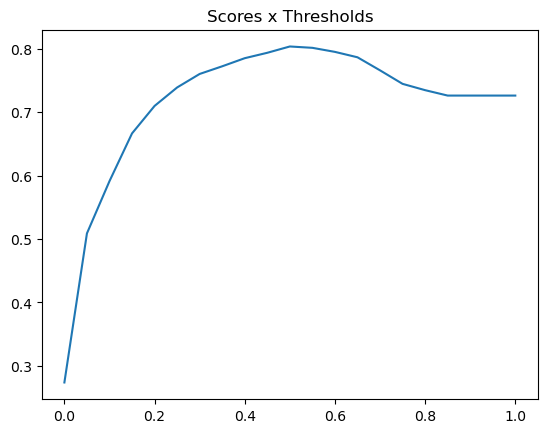

In [14]:
plt.plot(thresholds, scores)
plt.title('Scores x Thresholds')

In [15]:
# Scikit-learn has the accuracy score, which does the same of what we did

from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [16]:
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [17]:
# Threshold = 1.0 -> no customer will be considered as churn

from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

# 4.3 Confusion table
- Different types of errors and correct decisions
- Arranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
predict_positive[:10]

array([False, False, False,  True, False, False, False, False,  True,
       False])

In [21]:
actual_positive[:10]

array([False, False, False,  True, False, False, False, False,  True,
        True])

In [22]:
predict_positive & actual_positive

# - this compares the True and False values of each list
# - when both are equal, it returns True
# - if the values are different, it returns False

array([False, False, False, ..., False,  True,  True])

In [23]:
(predict_positive & actual_positive).sum()

210

In [24]:
tp = (predict_positive & actual_positive).sum() # tp = true positive
tn = (predict_negative & actual_negative).sum() # tn = true negative

In [25]:
tn

922

In [26]:
fp = (predict_positive & actual_negative).sum() # fp = false positive
fn = (predict_negative & actual_positive).sum() # fn = false negative

fp, fn

(101, 176)

In [27]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [28]:
# Confusion matrix in percentage

(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# 4.4 Precision and recall

In [29]:
# Accuracy

(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

### Precision

In [30]:
p = tp / (tp + fp)
p

0.6752411575562701

In [31]:
tp + fp # 311 customers are going to receive our promotional email, and 33% are mistaken

311

### Recall

In [32]:
r = tp / (tp + fn)
r

0.5440414507772021

In [33]:
tp + fn # for 386 customers that churned, we failed to identify 46% of them

386

# 4.5 ROC curves

TPR (true positive rate) and FRP (false positive rate)

In [34]:
# TPR (true positive rate)

tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [35]:
# TPR is the same as recall

r

0.5440414507772021

In [36]:
# FPR (false positive rate) -> we want to minimize FPR as low as possible

fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [37]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [38]:
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 330, 341, 56, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 304, 70, 719),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [39]:
pd.DataFrame(scores)

,0,1,2,3,4
0,0.00,386,1023,0,0
1,0.01,385,913,1,110
2,0.02,384,830,2,193
3,0.03,383,766,3,257
4,0.04,381,715,5,308
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [40]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [41]:
df_scores[::10] # shows first to last obs with increments of 10

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [42]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [43]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


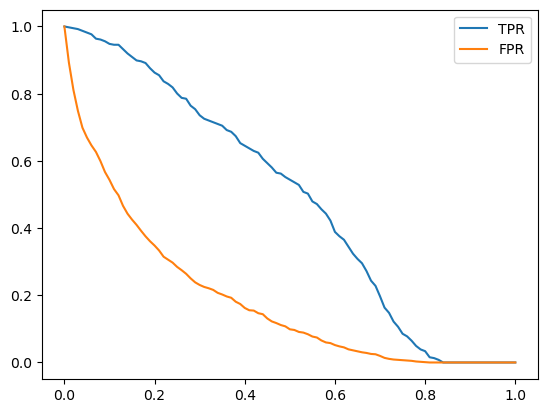

In [44]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [45]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [46]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [47]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [48]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [49]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


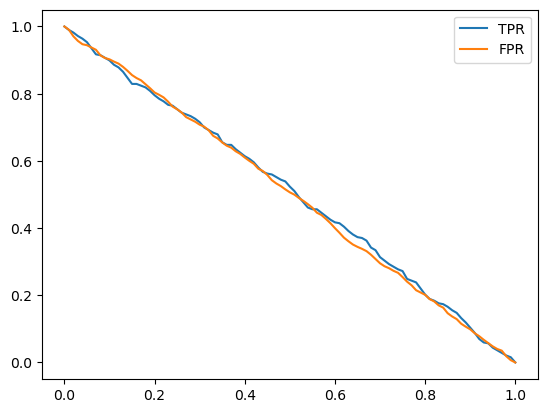

In [50]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [51]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(1023, 386)

In [52]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos]) # this is our val dataset, in a way
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [53]:
np.linspace(0, 1, len(y_val))

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [54]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [55]:
1 - y_val.mean()

0.7260468417317246

In [56]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [57]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [58]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


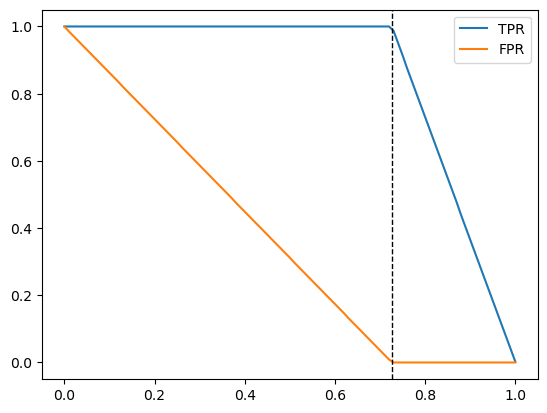

In [59]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.axvline(x=0.726, color='black', linestyle='--', linewidth=1)
plt.legend()

# the ideal threshold would be 0.726

### Putting everything together

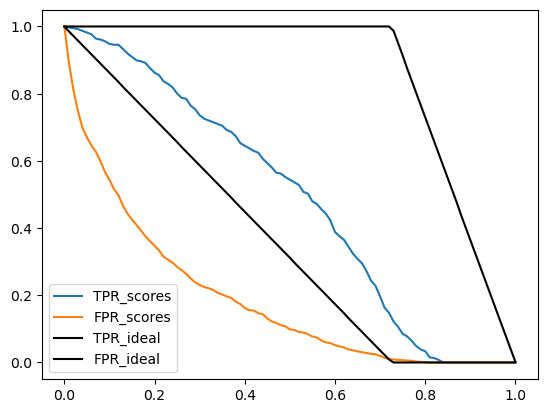

In [60]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR_scores')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR_scores')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR_random')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR_random')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR_ideal', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR_ideal', color='black')
# plt.axvline(x=0.726, color='black', linestyle='--', linewidth=1)

plt.legend()

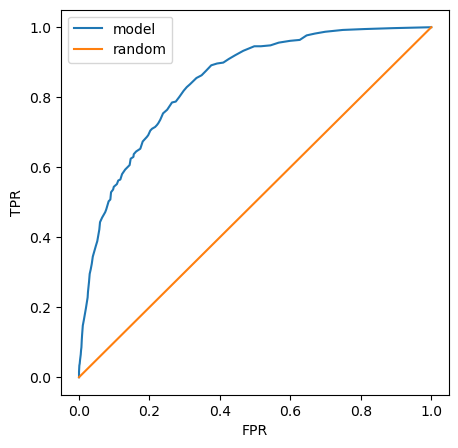

In [61]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label='rand')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [62]:
from sklearn.metrics import roc_curve

In [63]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

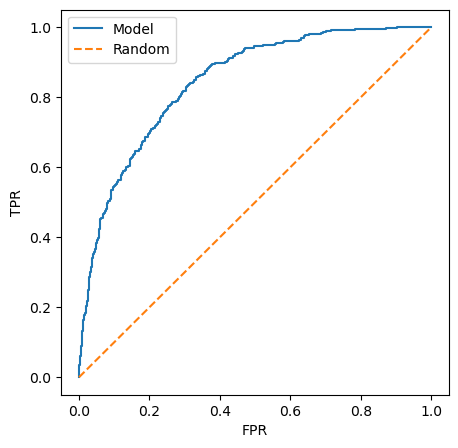

In [64]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# 4.6 ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC
- AUC = Area Under the roc Curve

In [65]:
from sklearn.metrics import auc

In [66]:
auc(fpr, tpr)

0.8438530381535563

In [67]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [68]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [69]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438530381535563

In [70]:
from sklearn.metrics import roc_auc_score

In [71]:
roc_auc_score(y_val, y_pred)

0.8438530381535563

In [72]:
y_val == 0

array([ True,  True,  True, ...,  True, False, False])

In [73]:
y_val == 1

array([False, False, False, ..., False,  True,  True])

In [74]:
y_pred[y_val == 0] # this brings the predictions for the obs in val dataset that did not churn

array([0.00899671, 0.20451158, 0.21221209, ..., 0.10786885, 0.31366544,
       0.13638835])

In [75]:
y_pred[y_val == 1] # this brings the predictions for the obs in val dataset that churned

array([0.54305033, 0.5822605 , 0.46169988, 0.73943128, 0.06580487,
       0.69175247, 0.2473645 , 0.69654047, 0.21207647, 0.6651053 ,
       0.47347066, 0.34864452, 0.15046291, 0.61755595, 0.76471988,
       0.14248481, 0.43289179, 0.27300983, 0.06885283, 0.19234485,
       0.67062443, 0.41597107, 0.66202857, 0.58315785, 0.52439177,
       0.43307912, 0.46856219, 0.35113944, 0.56775049, 0.32176938,
       0.63521704, 0.74370139, 0.73843527, 0.60892849, 0.70873071,
       0.76478396, 0.10729107, 0.18071624, 0.54201936, 0.57943364,
       0.43656266, 0.44060335, 0.75707355, 0.38574015, 0.69438771,
       0.41765278, 0.7578679 , 0.30225639, 0.53390727, 0.58068113,
       0.15407866, 0.52946728, 0.78578601, 0.43642787, 0.6732628 ,
       0.7744061 , 0.01263681, 0.35107447, 0.79769695, 0.58466261,
       0.67392181, 0.24822215, 0.34498322, 0.7016359 , 0.20960951,
       0.68593505, 0.63630482, 0.29106243, 0.66050501, 0.30801321,
       0.50166319, 0.27181781, 0.39709674, 0.41040001, 0.49931

In [76]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [77]:
len(X_val), len(y_val)

(1409, 1409)

In [78]:
Counter(y_val) # total = 1409

Counter({0: 1023, 1: 386})

In [79]:
Counter(y_pred >= 0.5) # total = 1409

Counter({False: 1098, True: 311})

In [80]:
len(y_val), len(y_test), len(y_pred)

(1409, 1409, 1409)

In [81]:
len(y_val), len(pos), len(neg) # pos + neg = 1409, as it should be

(1409, 386, 1023)

In [82]:
import random

In [83]:
pos_ind = random.randint(0, len(pos) - 1) # index of positive observations
neg_ind = random.randint(0, len(neg) - 1) # index of negative observations

pos_ind, neg_ind

(232, 576)

In [84]:
pos[pos_ind] > neg[neg_ind]

True

In [85]:
n = 10000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1
        
success / n

0.8459

In [86]:
len(pos), len(neg) 
# we set the value of indexes to 10000, but there are 386 for pos and 1023 for neg
# then we can conclude that it repeats indexes and makes lots of combinations

(386, 1023)

In [87]:
# Vectorizing the AUC with np.random

n = 10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [88]:
neg[neg_ind]

array([0.56314928, 0.48298583, 0.58719638, ..., 0.03327103, 0.00497696,
       0.10028101])

In [89]:
pos[pos_ind] > neg[neg_ind]

array([False,  True,  True, ...,  True,  True,  True])

In [90]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.8352

In [91]:
n = 50000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

# this is a common way of measuring the performance of a binary classification model

0.84646

# 4.7 Cross-Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [92]:
def train(df_train, y_train, C=1.0): # the parameter C is used to tune our model (default vale = 1)
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [93]:
dv, model = train(df_train, y_train, C=0.001)

In [94]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [95]:
y_pred = predict(df_val, dv, model)

In [96]:
from sklearn.model_selection import KFold

In [97]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1) # separate de dataset into 10 parts, train the model with 90%

In [98]:
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x000001B18EB86200>

In [99]:
next(kfold.split(df_full_train))

(array([   0,    1,    2, ..., 5631, 5632, 5633]),
 array([   4,   21,   28,   33,   44,   58,   67,   72,   79,   81,   82,
          98,  101,  116,  119,  125,  126,  136,  141,  147,  161,  169,
         179,  192,  196,  200,  206,  214,  222,  231,  250,  255,  259,
         276,  280,  285,  301,  308,  313,  314,  325,  343,  354,  359,
         383,  386,  407,  420,  428,  433,  440,  447,  457,  473,  486,
         496,  501,  503,  507,  545,  554,  557,  566,  574,  580,  582,
         592,  605,  608,  623,  634,  636,  645,  662,  667,  684,  687,
         689,  729,  745,  758,  763,  778,  783,  792,  795,  808,  839,
         840,  847,  850,  858,  867,  870,  871,  881,  899,  906,  927,
         929,  931,  940,  943,  976,  984,  987,  988, 1005, 1016, 1028,
        1034, 1038, 1050, 1056, 1074, 1079, 1117, 1122, 1123, 1131, 1134,
        1139, 1144, 1155, 1159, 1163, 1169, 1179, 1198, 1206, 1216, 1238,
        1247, 1256, 1272, 1297, 1298, 1310, 1344, 1356, 1370,

In [100]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [101]:
len(train_idx), len(val_idx)

(5070, 564)

In [102]:
len(df_full_train)

5634

In [103]:
df_full_train.iloc[train_idx]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
611,4765-oxppd,female,0,yes,yes,9,yes,no,dsl,yes,...,yes,yes,no,no,month-to-month,no,mailed_check,65.00,663.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2250-ivbwa,male,0,yes,yes,64,yes,no,fiber_optic,yes,...,no,no,no,no,month-to-month,no,electronic_check,81.05,5135.35,0
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [104]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [105]:
!pip install tqdm

In [106]:
from tqdm.auto import tqdm

In [107]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.006
C=1 0.840 +- 0.008
C=5 0.840 +- 0.008
C=10 0.841 +- 0.008


In [108]:
# C=1 (default value) looks fine

In [109]:
np.mean(scores), np.std(scores)

(0.841100846225606, 0.007871995525904806)

In [110]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.841 +- 0.008


In [111]:
scores

[0.8424574734478887,
 0.8458585783339956,
 0.8326349588601243,
 0.8320070186097078,
 0.8525462018763139]

In [112]:
# Train our final model

dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

# The score is a little bit better than 0.841

0.8572386167896259